In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue May  9 15:50:35 2023

@author: trevizo

Markets forecast using time series ARIMA model

"""

'\nCreated on Tue May  9 15:50:35 2023\n\n@author: trevizo\n\nMarkets forecast using time series ARIMA model\n\n'

In [2]:
# %% Load the Libraries
#
import pandas as pd
from pandas.api.types import is_numeric_dtype
from pandas import DataFrame, date_range, concat
import numpy as np
from math import log, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.tsa.seasonal as sts
from statsmodels.tsa.seasonal import STL
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
import statsmodels.graphics.tsaplots as splt
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# https://anaconda.org/anaconda/pandas-datareader
# conda install -c anaconda pandas-datareader
# or pip install pandas-datareader
import pandas_datareader.data as rdr
import datetime as dt


# Create a date out of the sting in the file.
from datetime import datetime


# Load the libraries

In [3]:
# Assign start and end dates to collect stock data
start = dt.datetime(2022,1,1)
# end = dt.datetime(2023,5,9)
# end = dt.datetime.now()
end = dt.datetime.today().date()

In [4]:
# Get stock data from stooq... use 'qqq' or 'spy' or other individual stock
df = rdr.DataReader("spy", "stooq", start, end)
df.describe()

,Open,High,Low,Close,Volume
count,441.000000,441.000000,441.000000,441.000000,4.410000e+02
mean,412.868068,415.867592,409.684978,412.913798,8.967826e+07
std,26.001623,25.490872,26.268284,25.872104,2.895041e+07
min,349.205000,359.817900,348.110000,356.560000,3.054543e+07
25%,393.220000,396.490000,390.140000,393.740000,7.015706e+07
50%,411.207000,413.240000,408.140000,411.090000,8.464106e+07
75%,435.663000,438.370000,433.551000,436.170000,1.030848e+08
max,473.720000,474.474000,470.121000,472.233000,2.554272e+08


In [5]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-10-04,422.07,425.4299,420.56,424.66,87452968.0
2023-10-03,425.06,427.3729,420.18,421.59,103760607.0
2023-10-02,426.62,428.6000,424.46,427.31,83798599.0
2023-09-29,431.67,431.8500,425.91,427.48,115111319.0
2023-09-28,425.48,430.2499,424.87,428.52,92258308.0


In [6]:
df = df.sort_index(ascending=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-01-03,470.835,472.372,468.415,472.233,7.351163e+07
2022-01-04,473.720,474.474,470.121,472.074,7.200478e+07
2022-01-05,471.688,472.501,462.912,463.011,1.057522e+08
2022-01-06,462.525,465.420,460.086,462.575,8.786699e+07
2022-01-07,462.585,463.814,459.322,460.741,8.609941e+07


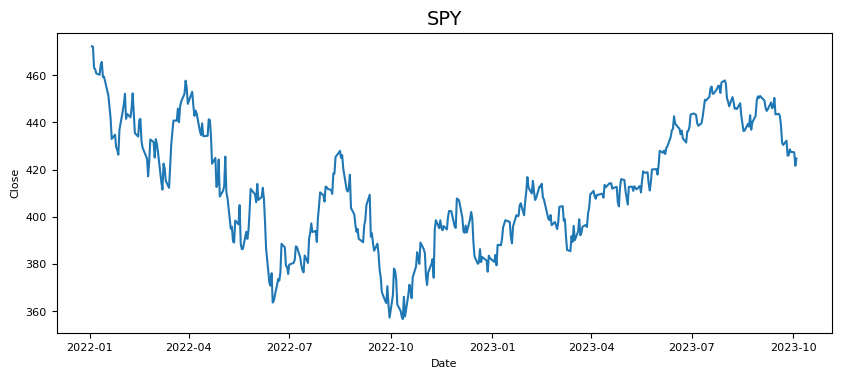

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.subplots_adjust(bottom=0.4,top=0.7)
ax = sns.lineplot(x='Date', y='Close', data=df, errorbar=None, ax=ax)
_=ax.set_title('SPY', fontsize=14)
_=ax.set_xlabel('Date', fontsize=8)
_=ax.set_ylabel('Close', fontsize=8)
_=ax.tick_params(labelsize=8)
plt.show()

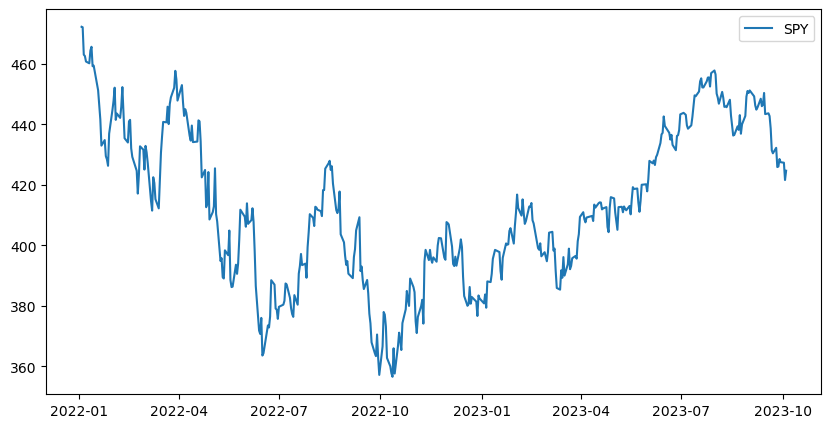

In [8]:
# %%% Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.Close, label='SPY')
plt.legend()
plt.show()

In [9]:
dec = sts.seasonal_decompose(df.Close, extrapolate_trend = 'freq', period = 12) 

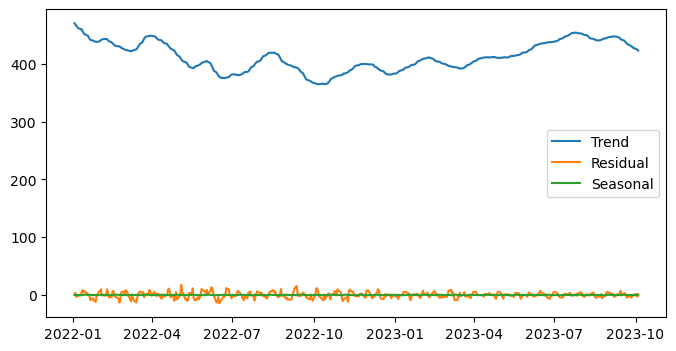

In [10]:
ts = pd.DataFrame({'resid': dec.resid, 
                         'trend': dec.trend, 
                         'seasonal': dec.seasonal},
                       index = df.index)

plt.figure(figsize=(8, 4))
plt.plot(ts.index, ts.trend, label='Trend')
plt.plot(ts.index, ts.resid, label='Residual')
plt.plot(ts.index, ts.seasonal, label='Seasonal')
#plt.ylim([-2.5, 12])
plt.legend()
plt.show()


# Auto ARIMA Model

In [11]:
best_model = pm.auto_arima(ts.trend, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             information_criterion = 'bic',
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,1)[12]             : BIC=inf, Time=2.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=1780.766, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=817.288, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=inf, Time=2.43 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=994.797, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : BIC=697.925, Time=1.62 sec
 ARIMA(1,1,0)(2,1,1)[12]             : BIC=inf, Time=7.32 sec
 ARIMA(1,1,0)(1,1,1)[12]             : BIC=inf, Time=3.18 sec
 ARIMA(0,1,0)(2,1,0)[12]             : BIC=1670.181, Time=0.32 sec
 ARIMA(2,1,0)(2,1,0)[12]             : BIC=632.735, Time=1.15 sec
 ARIMA(2,1,0)(1,1,0)[12]             : BIC=728.791, Time=0.65 sec
 ARIMA(2,1,0)(2,1,1)[12]             : BIC=inf, Time=16.31 sec
 ARIMA(2,1,0)(1,1,1)[12]             : BIC=inf, Time=5.32 sec
 ARIMA(3,1,0)(2,1,0)[12]             : BIC=628.065, Time=2.54 sec
 ARIMA(3,1,0)(1,1,0)[12]             : BIC=719.888, Ti

# Predict

In [12]:
# %% Predict
num_preds = 100
# Predictions to compare results to actuals
prediction = pd.DataFrame({'pred': best_model.predict(n_periods=num_preds)})

# Make it a time series => Set the index to the proper dates
# pred_start_date = pd.to_datetime('2023-05-10')
pred_start_date = end
pred_dates = pd.date_range(start=pred_start_date, periods=num_preds, freq='D')
prediction.set_index(pred_dates, inplace = True)
prediction.tail()

,pred
2024-01-08,307.929718
2024-01-09,306.476342
2024-01-10,305.116224
2024-01-11,303.903863
2024-01-12,302.713318


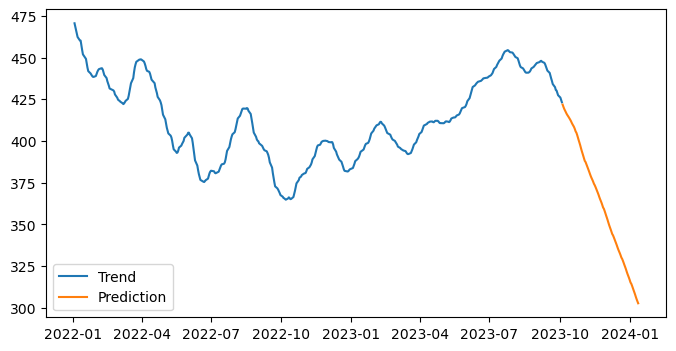

In [13]:
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(ts.index, ts.trend, label='Trend')
plt.plot(prediction.index, prediction.pred, label='Prediction')
#plt.ylim([4, 12])
plt.legend()
plt.show()
